In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import copy
sns.set()
%matplotlib inline 

# Tarea 4: Busqueda de imagenes
Integrantes : Francisco Muñoz y Patricio López

Para ejecutar este notebook se recomienda clonar o descargar el repositorio que contiene todo el codigo fuente, modelos entrenados y datos [aqui](https://github.com/Francisco95/ImageSearch)


### Descripcion del problema:
Crear un buscador de imagenes, donde se describa con palabras lo que se quiere buscar y encuentre las imagenes que mejor coinciden con el contenido del texto.

### Herramientas disponibles:
* Conjunto de imagenes sacadas del dataset de COCO, teniendo para cada una:
    * un vector de caracteristicas con tamaño 2048 para imagenes previamente entrenadas
    * 5 ejemplos de captions (texto) que se relacionen con dicha imagen, en español
* Libre uso de librerias python en tanto sean codigo libre
    * sklearn
    * keras
    * scipy
    * numpy
    * matplotlib
    * pandas
    * seaborn
    * stop-words
    
### Solucion planteada:
Primero es necesario obtener la informacion relevante de cada caption y traducirla a algun formato vectorial, con lo cual se planea entrenar un regresor que entregue una prediccion del vector de caracteristicas correspondiente al texto. Luego, para cada nueva consulta, basta con regresionar el vector de caracteristicas y realizar un similarity-search para obtener la imagen que mejor coincida.

El objetivo de esta tarea (y este notebook) es mostrar este procedimiento y realizar todas las validaciones y experimentos necesarios para asegurar que el procedimiento planteado puede ser efectivamente aplicado para buscar imagenes.

### Estructura del notebook:
Los pasos realizados durante esta tarea son:
* [Construccion del regressor](#Creacion-de-un-Regresor): Se explica cómo se construye el regressor utilizado y se muestra un ejemplo de su entrenamiento y el cómo se verifica que es un buen modelo (sin overfitting ni underfitting)
* [Casos de estudio](#Casos-de-estudio): Se presentan los 6 casos de estudio que seran utilizados para realizar los experimentos, especificando los metodos que se utilizaran para obtener los descriptores de texto. Aquí se cargan sus regresores y se muestra que ninguno de ellos tiene overffiting.
* [Experimentos](#Experimentos): Se cargan los dataset de prueba (A, B, C), se obtienen sus descriptores de texto para cada experimento y se realizan las similarity search.
* [Resultados y análisis](#Resultados-y-Análisis): Se obtienen una serie de indicadores en base a los resultados del similarity search, luego se muestran y analizan estos resultados.
* [Ejemplos prácticos](#Ejemplo-práctico:-Buscando-una-imagen): se muestran algunos ejemplos de los resultados obtenidos, donde se introduce un texto y se muestra las imagenes que mejor coinciden con el texto buscado
* [#Conclusiones finales](#Conclusiones-finales): Por ultimo se concluye sobre los resultados obtenidos, combinando con la teoría y chequeando si se cumplieron los comportamientos esperados.

## Regresor: NN utilizando keras
Para realizar la regresion lineal que entrege los vectores de caracteristicas de una imagen buscada, se utiliza la librería keras. Con esta librería, se define una red MLP donde la última capa no aplique ningun activador ni un soft-max. Para simplificar el contenido de este notebook, hemos implementado nuestro regresor en una libreria a parte, desde la cual importamos lo siguiente:

In [2]:
from src.regressor import Regressor, r_square, rmse

Using TensorFlow backend.


Es posible ver los métodos definidos dentro al utilizar la función python help o accediendo directamente a la carpeta contenedora del código que sera adjuntada con la entrega, dentro de la carpeta src.

Para agilizar el proceso, todos los regresores que se utilizarán en la obtención de los indicadores serán cargados desde disco. Pero a continuacion mostraremos el procedimiento necesario para entrenar un nuevo modelo, incluyendo la verificacion de overfitting y cómo guardar el modelo resultante en disco.

### Cálculo de los descriptores de texto
El primer paso es obtener los vectores que describen cada una de las 100000 frases contenidas en el set de entrenamiento. Se implementan dos alternativas para este procedimiento:
* CountVectorizer: Separa el texto en tokens y realiza una cuenta sobre las repeticiones para obtener un vocabulario y asi generar los descriptores de texto. Tambien implementa ngram para incrementar el tamaño del vector y stop-words para evitar palabras innecesarias.
* TF-IDF: Term frecuency - inverse document frecuency, genera descriptores de texto basado en el producto de la frecuencia de aparición de cada término en cada documento por el inverso de la cantidad de documentos que contienen al término i-esimo sobre la cantidad total de documentos, ajustado logaritmicamente. Lo que da un valor bastante representativo para el vector de cada documento en base a la frecuencia de aparición, y resalta aquellos términos que solo aparecen en ciertos textos, mientras que disminuye aquellos que aparecen en varios textos.

Ambas alternativas deben ser configuradas por medio de una serie de parámetros. Varios de estos parametros seran primordiales al momento de entrenar distintos Regressores.

Nuevamente, todo el código relativo a esta implementacion es creada en un código python externo a este notebook y debe ser importado de la siguiente manera:

In [3]:
from src.filehandler import DataHandler

#### Cargando los datos de entrenamiento
En esta sección, se creara un Regresor utilizando TF-IDF como generador de vectores. La configuracion a utilizar sera:
* ngram-range = (1, 3)
* stop-words = spanish

In [4]:
stop_words = get_stop_words('spanish')
# debemos indicar el directorio que contiene los datos y los sub-directorios que contienen cada dataset
data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
# y obtenemos nuestros vectores
X_train, X_test, y_train, y_test = data.get_data(method="tf-idf", stop_words=stop_words, ngram_range=(1, 3), verbose=False)
print("shapes")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

shapes
X_train: (100000, 640)
y_train: (100000, 2048)
X_test: (5000, 640)
y_test: (5000, 2048)


#### Creando el regresor
Luego creamos un regressor para este tamaño de vectores, con dos capas escondidas, cada una de 200 neuronas. La red MLP tendra la siguiente configuracion:
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True


Adicionalmente, se implementa un Early Stopping con una paciencia de 4 epocas y que monitorea el loss de validación, de forma que cuando deje de decrecer o empiece a aumentar, detenga el entrenamiento y evite un overfitting. Además, se monitorea la métrica de MAE (mean absolute error), RMSE (root mean square error) y R-square.

In [5]:
in_dim = X_train.shape[1]
out_dim = y_train.shape[1]
reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=2, layer_size=200, 
                loss='mean_squared_error', optimizer='adam', metrics=['mae', rmse, r_square])
reg.build()
history = reg.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True)

W0709 15:13:36.244998  9924 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 15:13:36.256992  9924 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 15:13:36.258960  9924 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0709 15:13:36.266963  9924 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 15:13:36.283894  9924 deprecation_wrapper.py:119] From c:\programda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               128200    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              411648    
Total params: 580,048
Trainable params: 580,048
Non-trainable params: 0
_________________________________________________________________


W0709 15:13:36.690269  9924 deprecation_wrapper.py:119] From c:\programdata\miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 5s 66us/step - loss: 0.6449 - mean_absolute_error: 0.4868 - rmse: 0.7912 - r_square: 0.1222 - val_loss: 0.5667 - val_mean_absolute_error: 0.4600 - val_rmse: 0.7414 - val_r_square: 0.2301
Epoch 2/100
80000/80000 [==============================] - 5s 63us/step - loss: 0.5458 - mean_absolute_error: 0.4519 - rmse: 0.7265 - r_square: 0.2570 - val_loss: 0.5333 - val_mean_absolute_error: 0.4422 - val_rmse: 0.7170 - val_r_square: 0.2755
Epoch 3/100
80000/80000 [==============================] - 5s 62us/step - loss: 0.5269 - mean_absolute_error: 0.4434 - rmse: 0.7127 - r_square: 0.2827 - val_loss: 0.5230 - val_mean_absolute_error: 0.4407 - val_rmse: 0.7097 - val_r_square: 0.2894
Epoch 4/100
80000/80000 [==============================] - 5s 63us/step - loss: 0.5193 - mean_absolute_error: 0.4399 - rmse: 0.7073 - r_square: 0.2930 - val_loss: 0.5184 - val_mean_absolute_error: 0.4396 - val_rm

#### Probando el regressor y validando resultados
Como se observa al ejecutar la celda de arriba, entrenar el modelo entrega información sobre las métricas al terminar cada época y se detiene cuando el loss de validación deja de bajar. Es posible evaluar el modelo en un nuevo dataset u obtener la historia de las metricas sobre el dataset de entrenamiento y validación. Con esto último se puede visualizar que el resultado no contiene ni overfitting ni underfitting dado que las curvas en ambos dataset se mantienen juntas.

evaluando test
5000/5000 [==============================] - 0s 40us/step
    EVALUATION RESULTS :  
loss: 0.51
mean_absolute_error: 0.44
rmse: 0.70
r_square: 0.30


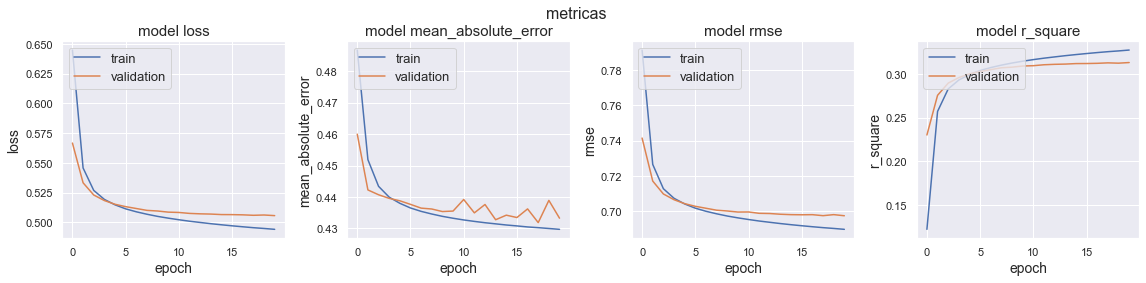

In [6]:
# graficar las metricas
reg.plot_metrics()

# evaluar el modelo
scores = reg.evaluate(X_test, y_test)

#### Guardando el regressor
Por último, el modelo debe ser guardado si se desea utilizar para situaciones posteriores, esto se realiza muy fácilmente de la siguiente forma:

saving model to disk ... done!
loading model from disk ... done!
evaluando test
5000/5000 [==============================] - 0s 49us/step
    EVALUATION RESULTS :  
loss: 0.51
mean_absolute_error: 0.44
rmse: 0.70
r_square: 0.30


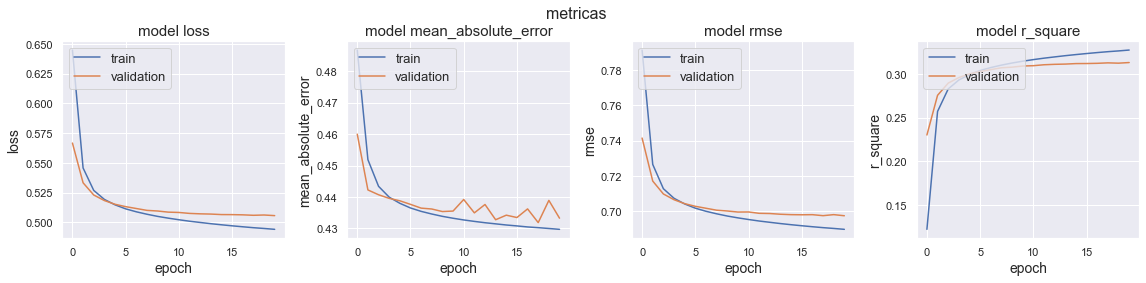

In [7]:
reg.save("test")
# se puede verificar esto al cargar el modelo en una nueva variable
reg2 = Regressor()
reg2.load("test", custom_objects={"rmse": rmse, "r_square": r_square})
# y veamos que evaluar el conjunto de test da los mismos resultados
score2 = reg2.evaluate(X_test, y_test)

# graficar las metricas
metrics = reg2.plot_metrics()

### Casos de estudio
Para este trabajo se opto por fijar una arquitectura para el regresor y estudiar diversas configuraciones en la obtención de los descriptores de texto. La arquitectura común para todos los casos de estudio sera la misma que fue utilizada en el ejemplo de arriba, en particular:

* capas internas:
    * fully-connected de 200 neuronas con activador ReLu
    * fully-connected de 200 neuronas con activador ReLu
* capa de salida: fully-connected de 2048 sin activador
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True
* Early Stopping : tolerancia de 0.005, con una paciencia de 4 epochas
* metricas monitoreadas : Mean Absolute Error, Root Mean Square Error, R-Square


Luego, los casos de estudio seran:

* Count-vectorizer con ngram_range = (1,1) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y con stop_words de español
* TF-IDF con ngram_range = (1,1) y sin stop_words
* TF-IDF con ngram_range = (1,4) y sin stop_words
* TF-IDF con ngram_range = (1,4) y con stop_words de español

Los regresores para cada uno de estos modelos se encuentran almacenados en la carpeta /model con nombres descriptivos de cada configuración, de forma que puedan ser cargados fácilmente. En caso de fallar la carga, debera entrenar todos los modelos usando el script adjunto. Esto no se incluye en el notebook para simplicifcar su contenido.

A continuación se presentan gráficos de cada uno de estos regressores para asegurar que ninguno de ellos presente overffiting.

cargando, evaluando y graficando regresores para 6 experimentos: ...... Done!


,MSE,MAE,RMSE,R2
cv_ngram11_none,0.514907,0.437129,0.704303,0.299002
cv_ngram14_none,0.520575,0.440264,0.708411,0.290992
cv_ngram14_stop_words,0.515872,0.439397,0.705112,0.297643
tf_idf_ngram11_none,0.514989,0.432423,0.704085,0.298931
tf_idf_ngram14_none,0.516810,0.443114,0.706048,0.296064
tf_idf_ngram14_stop_words,0.515313,0.438198,0.704616,0.298323


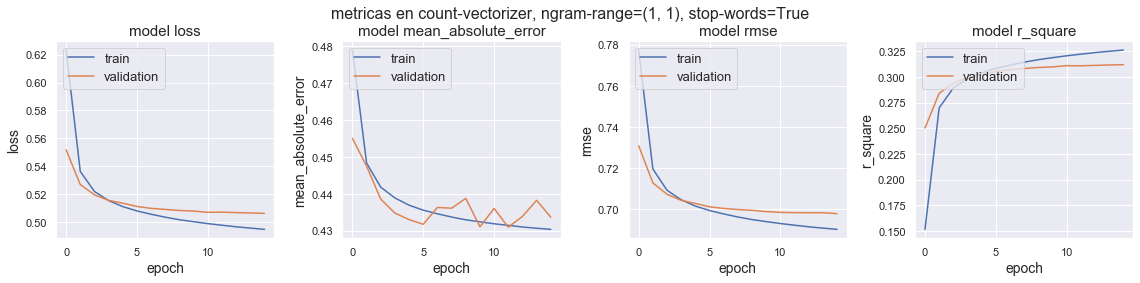

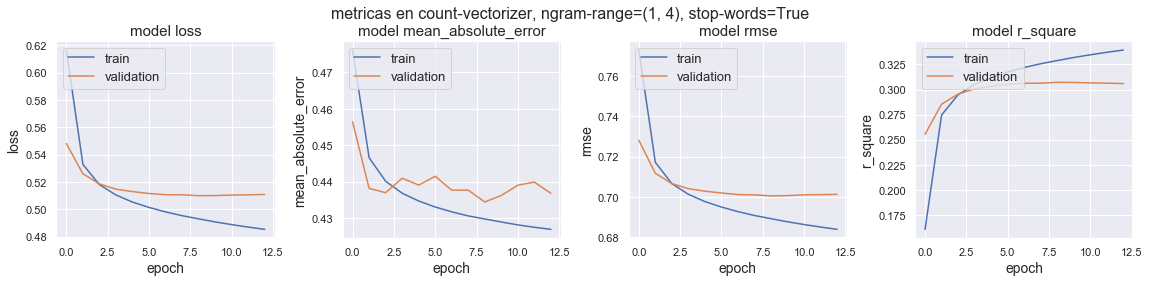

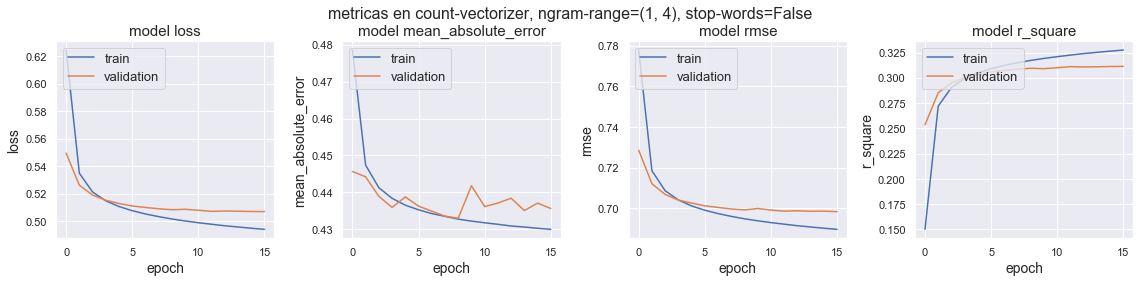

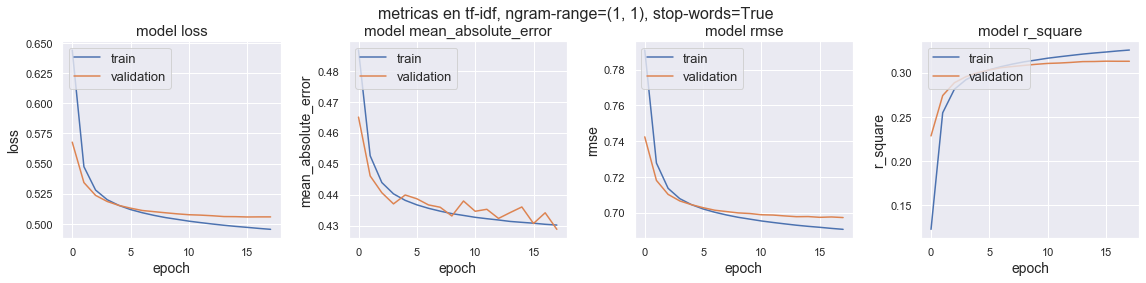

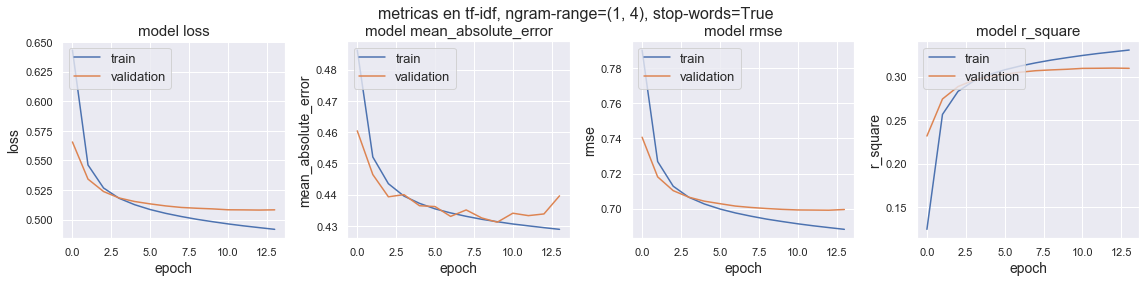

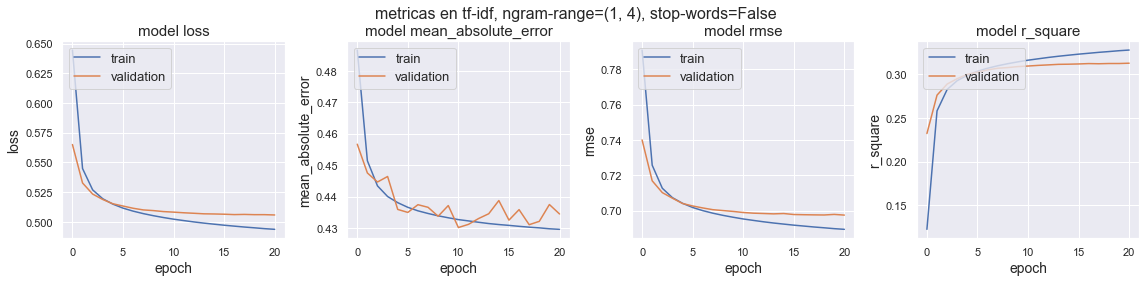

In [8]:
# ========= global variables for the experiments ==============
stop_words = get_stop_words('spanish')
methods = ["count-vectorizer"] * 3 + ["tf-idf"] * 3
ngram_ranges = [(1, 1), (1, 4), (1, 4)] * 3
stop_words_list = ([None] * 2 + [stop_words]) * 2
models = ["cv_ngram11_none", "cv_ngram14_none", "cv_ngram14_stop_words",
          "tf_idf_ngram11_none", "tf_idf_ngram14_none", "tf_idf_ngram14_stop_words"]
data_A = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
data_B = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_B_data")
data_C = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_C_data")
# ====================================================================

def get_regressors(data):
    regs = []
    metrics = {}
    print("cargando, evaluando y graficando regresores para 6 experimentos: ", end="")
    for method, model, ngram_range, sw in zip(methods, models, ngram_ranges, stop_words_list):
        reg = Regressor()
        X_train, X_test, y_train, y_test = data.get_data(method=method, stop_words=sw, 
                                                         ngram_range=ngram_range, verbose=False)
        reg.load(model, custom_objects={"rmse": rmse, "r_square": r_square}, verbose=False)
        reg.plot_metrics("metricas en {}, ngram-range=({}, {}), stop-words={}".format(method, ngram_range[0],
                                                                                      ngram_range[1], (not sw)))
        scores = reg.evaluate(X_test, y_test, verbose=False)
        metrics[model] = scores
        regs.append(reg)
        print(".", end="")
    print(" Done!")
    return regs, metrics
regs, metrics = get_regressors(data_A)
df = pd.DataFrame.from_dict(metrics, orient="index", columns=["MSE", "MAE", "RMSE", "R2"])
df

Donde se observa que el loss del set de validación siempre se mantiene cercano al loss de entrenamiento, característica crucial para evitar el overfitting. Se presentan adicionalmente otras métricas utilizadas en regressiones (RMSE, MAE, R2) y todas siempre se mantienen similares para entrenamiento y validación. Todo esto sugiere claramente que se han entrenado los regresores correctamente.

### Experimentos

Para estudiar los resultados obtenidos por la regresión vamos a calcular varias métricas más, las que son:
* Silimarity search, busqueda de los más cercanos. Para los 5000 vectores de test se guardan
  las posiciones de los 1000 vectores más cercanos, de 1000 vectores, lo que se traduce en un
  ordenamiento de las predicciones segun distancia entre el descriptor de texto y el de imagen.
* Un vector de posiciones correctas, para cada descriptor de texto se calcula donde está ubicada
  la respuesta correcta dada la matriz obtenida en similarity search, serian 5000 números entre
  el 1 y el 1000. Con esto se muestra un histograma para visualizar mejor la frecuencia de las posiciones.
* Recall@k, que correspode al porcentaje de esos 5000 números que son menores o iguales a K.
  Especificamente se calcula recall@1, recall@5 y recall@10.
* MRR o mean reciprocal rank
* Posición promedio del vector de posiciones correctas.


In [9]:
# funciones útiles
import src.utils as utils
#cargar medidor de indicadores para Similarity search, recall at k, MRR y Mean
from src.indicators import Indicators
ind = Indicators()

#### Crear descriptores de texto para los test propuestos

Primero cargamos los datos necesarios para calcular los descriptores de texto, para los 6 test
descritos más arriba.

In [10]:
X_tests = []
def get_X_tests(data):
    methods = ["count-vectorizer"] * 3 + ["tf-idf"] * 3
    ngram_ranges = [(1, 1), (1, 4), (1, 4)] * 3
    stop_words_list = ([None] * 2 + [stop_words]) * 2
    X_tests = []
    print("cargando datos y obteniendo descriptores de texto para 6 experimentos: ", end="")
    for method, ngram_range, sw in zip(methods, ngram_ranges, stop_words_list):
        X_tests.append(data.get_data_test(method=method, stop_words=sw, ngram_range=ngram_range, verbose=False))
        print(".", end="")
    print(" Done!")
    return X_tests
X_tests = get_X_tests(data_A)

cargando datos y obteniendo descriptores de texto para 6 experimentos: ...... Done!


#### Calcular indicadores

Calculamos los vectores resultantes de evaluar los test en las regresiones, y se cargan tambien los descriptores de imagen de largo 1000, para hacer luego el similarity search.

In [11]:
#calculamos los vectores resultantes del predict para cada test
def get_vectors(regs, X_tests):
    vectores = []
    print("obteniendo vectores predichos por cada red para los 6 experimentos: ", end="")
    for reg, X_test in zip(regs, X_tests):
        vectores.append(reg.predict(X_test))
        print(".", end="")
    print(" Done!")
    return vectores

vectores = get_vectors(regs, X_tests)
#cargamos los descriptores de imagenes
y_simple_test_A = data_A.load_simple_test("A", verbose=False) #este es el que usaremos a priori
#los test B y C se usaran para hacer una validacion final para ver si hay overfitting
y_simple_test_B = data_B.load_simple_test("B", verbose=False)
y_simple_test_C = data_C.load_simple_test("C", verbose=False)

obteniendo vectores predichos por cada red para los 6 experimentos: ...... Done!


In [12]:
def get_ranks_data(test_data, vectors):
    print("::::::::::::::::: obteniendo los ranks para cada experimento :::::::::::::::::::::::")
    print(":::::::::::::::::         se utiliza multiprocessing         :::::::::::::::::::::::")
    ranks = []
    data = []
    for vector in vectors:
        ranks.append(ind.similarity_search(test_data, vector, verbose=False))
        data.append(ind.get_formated_data())
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::")
    return ranks, data
ranks, results = get_ranks_data(y_simple_test_A, vectores)

::::::::::::::::: obteniendo los ranks para cada experimento :::::::::::::::::::::::
:::::::::::::::::         se utiliza multiprocessing         :::::::::::::::::::::::
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 39.294]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 36.85]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 39.57]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 40.724]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 38.513]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 39.003]
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


### Resultados y Análisis

Luego de calculados los vectores de posiciones, se grafican sus respectivos histogramas y una tabla con las métricas mencionadas anteriormente.

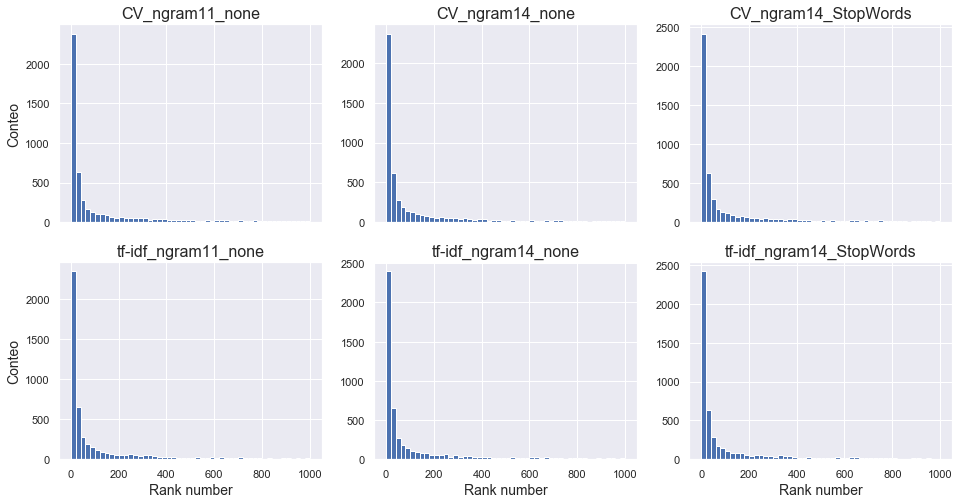

In [13]:
labels = ['recall@1','recall@5','recall@10','MRR','Mean', "MSE", "MAE", "RMSE", "R2"]
index = ['CV_ngram11_none', 'CV_ngram14_none','CV_ngram14_StopWords',
         'tf-idf_ngram11_none', 'tf-idf_ngram14_none','tf-idf_ngram14_StopWords']
def mix_data(result_exp, metrics, keys):
    results_copy = copy.deepcopy(result_exp)
    table_Data = []
    for i, k in enumerate(keys):
        table_data.append(results_copy[i])
        table_data[-1].extend(metrics[k])
    return table_data

def plot_hists(ranks, index):
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
    for i in range(6):
        j = i % 3
        k = 1 if i >= 3 else 0
        ax[k][j].hist(ranks[i], 50)
        ax[k][j].set_title(index[i], fontsize=16)
        if j == 0:
            ax[k][j].set_ylabel("Conteo", fontsize=14)
        if k == 1:
            ax[k][j].set_xlabel("Rank number", fontsize=14)
table_data = []
table_data = mix_data(results, metrics, models)
tabla = utils.get_table(table_data, index, labels)
plot_hists(ranks, index)

Se observa en los histograma que hay una alta frecuencia cerca de las primeras posiciones, que va desapareciendo para números más altos. Lo que indica que las imágenes tienden a ubicarse cerca de sus descriptores de texto asociados. Veamos más adelante cuan buenos son estos resultados.

#### Tabla resumen de experimentos para el dataset de test A

In [14]:
tabla

,recall@1,recall@5,recall@10,MRR,Mean,MSE,MAE,RMSE,R2
CV_ngram11_none,0.0600,0.2192,0.3416,0.147287,123.0534,0.514907,0.437129,0.704303,0.299002
CV_ngram14_none,0.0636,0.2266,0.3402,0.150460,119.7922,0.520575,0.440264,0.708411,0.290992
CV_ngram14_StopWords,0.0652,0.2228,0.3458,0.152514,119.9920,0.515872,0.439397,0.705112,0.297643
tf-idf_ngram11_none,0.0644,0.2208,0.3376,0.149207,122.3534,0.514989,0.432423,0.704085,0.298931
tf-idf_ngram14_none,0.0678,0.2246,0.3464,0.153862,118.4948,0.516810,0.443114,0.706048,0.296064
tf-idf_ngram14_StopWords,0.0692,0.2248,0.3450,0.155181,119.1726,0.515313,0.438198,0.704616,0.298323


#### Analisis

Se observa que todos los experimentos tienen metricas muy parecidas, pero el que tiene las mejores métricas en general es el TF-IDF con ngram_range = (1,4) y con stop_words de español. Entonces probaremos con los test B y C para ver si tienen metricas similares tambien.

In [15]:
def get_for_dataset(dataset, reg, y_simple_test):
    print(":::::: TEST SET ADICIONAL :::::::::::")
    print("~ obteniendo datos")
    X_test= dataset.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4), verbose=False)
    _, X_test_full, _, y_test_full = dataset.get_data(method="tf-idf", stop_words=stop_words, 
                                                   ngram_range=(1,4), verbose=False)
    print("~ pasando datos por el regresor")
    vectores = reg.predict(X_test)
    scores_test = reg.evaluate(X_test_full, y_test_full, verbose=False)
    print("~ realizando busquedas y obteniendo indicadores (usando multiprocessing)")
    rank_test = ind.similarity_search(y_simple_test, vectores, verbose=False)
    datos_test = ind.get_formated_data()
    datos_test.extend(scores_test)
    return datos_test, rank_test
    
datos_test_B, rank_test_B = get_for_dataset(data_B, regs[5], y_simple_test_B)
datos_test_C, rank_test_C = get_for_dataset(data_B, regs[5], y_simple_test_B)
datos_test_A = table_data[5]
rank_test_A = ranks[5]

:::::: TEST SET ADICIONAL :::::::::::
~ obteniendo datos
~ pasando datos por el regresor
~ realizando busquedas y obteniendo indicadores (usando multiprocessing)
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 41.152]
:::::: TEST SET ADICIONAL :::::::::::
~ obteniendo datos
~ pasando datos por el regresor
~ realizando busquedas y obteniendo indicadores (usando multiprocessing)
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 38.874]


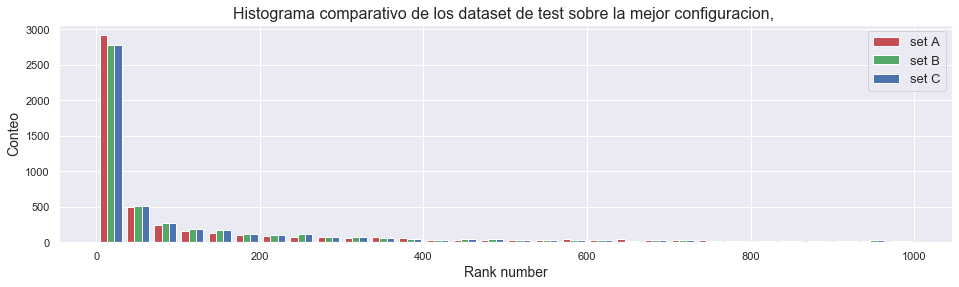

In [16]:
def plot_hist_per_test(ranks, colors, labels, bins=30, additional=""):
    plt.figure(figsize=(16, 4))
    plt.hist(ranks, bins, color=colors, label=labels)
    plt.legend(fontsize=13)
    plt.xlabel("Rank number", fontsize=14)
    plt.ylabel("Conteo", fontsize=14)
    plt.title("Histograma comparativo de los dataset de test sobre la mejor configuracion, {}".format(additional), 
              fontsize=16)
plot_hist_per_test([rank_test_A, rank_test_B, rank_test_C], ["r", "g", "b"], ["set A", "set B", "set C"])

Se observa que los resultados tienden a ser muy parecidos para los 3 dataset de test propuestos, lo cual nos confirma que no existe overfitting.

#### Zoom sobre el histograma
Dado que la mayoría de los resultados se encuentran agrupados bajo el rank 150, repetiremos el histograma solo para este segmento para observar una mejor resolución

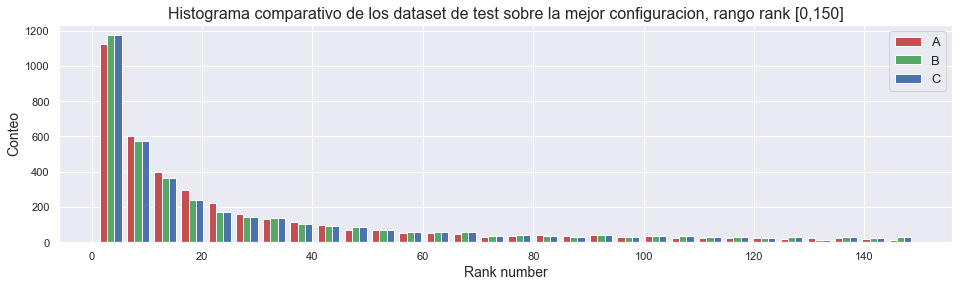

In [17]:
max_rank = 150
plot_hist_per_test([rank_test_A[rank_test_A < max_rank], 
                    rank_test_B[rank_test_B < max_rank], 
                    rank_test_C[rank_test_C < max_rank]], ["r", "g", "b"], ["A", "B", "C"], 
                   additional="rango rank [0,{}]".format(max_rank))

Se observa una curva similar para los 3 dataset, reafirmando lo dicho anteriormente.

In [18]:
index = ['Test_A', 'Test_B','Test_C']
datos = [datos_test_A, datos_test_B, datos_test_C]
tabla = utils.get_table(datos, index, labels)
tabla

,recall@1,recall@5,recall@10,MRR,Mean,MSE,MAE,RMSE,R2
Test_A,0.0692,0.2248,0.3450,0.155181,119.1726,0.515313,0.438198,0.704616,0.298323
Test_B,0.0732,0.2348,0.3498,0.157697,120.7294,0.520663,0.441791,0.707988,0.291125
Test_C,0.0732,0.2348,0.3498,0.157697,120.7294,0.520663,0.441791,0.707988,0.291125


Los test B y C muestran un recall@1 ligeramente mayor, pero en general todas las métricas tienen valores muy cercanos.

### Ejemplo práctico: Buscando una imagen
Utilizaremos el set de datos de test A y entregaremos alguna descripcion con el objetivo de recuperar las mejores imágenes segun la red y el similarity search.

Para ejecutar este ejemplo debes tener descargado las imagenes del dataset de test A y saber su ubicación en tu computador (no importa donde lo guardes, pero necesitaremos saber su locación). En el computador donde se realizó esta prueba, las imagenes se guardaron  en ./data/test_A_images

Nota: el siguiente pedazo de código puede ser ejecutado independientemente de todo lo anterior

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from src.regressor import Regressor, r_square, rmse
from src.filehandler import DataHandler
from stop_words import get_stop_words
from src.indicators import Indicators
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def setup(test_folder="/test_A_data"):
    # cargamos los datos
    data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder=test_folder)
    image_names, image_vectors, image_test_captions = data.load_test(verbose=False, n=1)
    _, _, image_captions = data.load_train(verbose=False)
    train_captions = image_captions[:,1]
    # entrenamos el descriptor correcto
    stop_words = get_stop_words('spanish')
    descr = TfidfVectorizer(lowercase=True,ngram_range=(1,4),max_df=0.8,min_df=0.002, stop_words=stop_words)
    descr.fit(train_captions)
    # cargamos el regressor correcto
    reg = Regressor()
    reg.load("tf_idf_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square}, verbose=False)
    # construimos el kdtree
    tree = spatial.KDTree(image_vectors)
    return reg, descr, image_names, tree, image_test_captions

search_reg, search_vectorizer, image_names, tree, image_captions = setup()

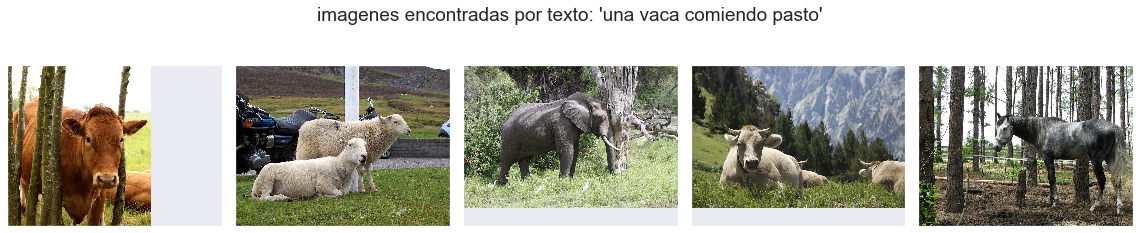

In [20]:
def search_image(text, image_names, reg, vectorizer, tree, n=5, img_folder="./data/test_A_images/"):
    # n indica el numero de imagenes que se mostraran
    m = int(np.ceil(n / 5))
    # obtenemos el descrioptor
    descriptor = vectorizer.transform([text])
    # pred image vector
    pred_image_vec = reg.predict(descriptor)
    # find n best match
    dists, idxs = tree.query(pred_image_vec, k=n)
    fig, ax = plt.subplots(m, 5, figsize=(16, 4 * m), sharex=True, sharey=True)
    for idx in range(n):
        i = idx // 5
        j = idx % 5
        img = mpimg.imread(img_folder + image_names[idxs[0][idx]])
        if m == 1:
            ax_idx = ax[j]
        else:
            ax_idx = ax[i][j]
        ax_idx.imshow(img)
        ax_idx.set_xticklabels([])
        ax_idx.set_yticklabels([])
        ax_idx.grid(b=None)
    
    fig.suptitle("imagenes encontradas por texto: '{}'".format(text), fontsize=19)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    return dists, idxs

_ = search_image("una vaca comiendo pasto", image_names, search_reg, search_vectorizer, tree, n=5)

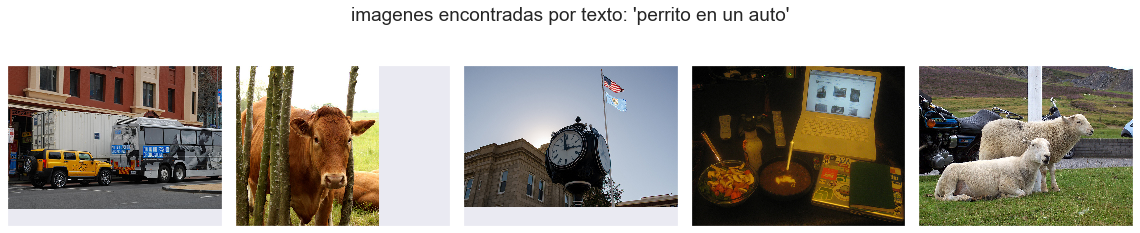

In [21]:
_ = search_image("perrito en un auto", image_names, search_reg, search_vectorizer, tree, n=5)

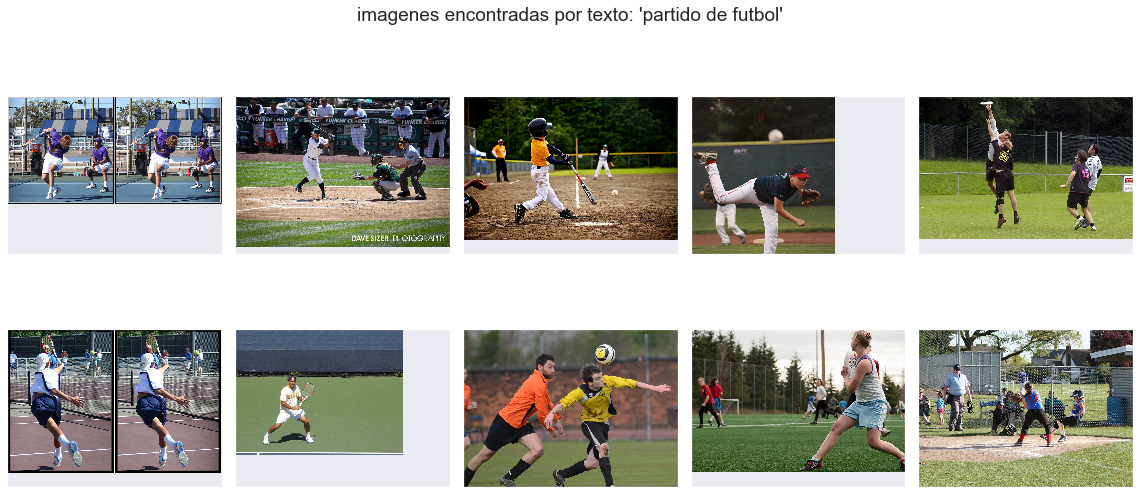

In [22]:
_ = search_image("partido de futbol", image_names, search_reg, search_vectorizer, tree, n=10)

#### comparando texto con los captions de una imagen
Por último realizaemos la búsqueda de una imagen con algún texto y compararemos los caption de la imagen resultante.

===> texto buscado: 'una vaca comiendo pasto'
===> mejor imagen relacionada al texto: 'COCO_train2014_000000084243.jpg'
===> Captions relacionados a esta imagen:
    -->  Un bovina se detiene mientras que el pastoreo en un grupo de árboles pequeños.
    -->  Una vaca está mirando hacia fuera de entre un árbol.
    -->  Una vaca mirando a la cámara entre un par de árboles.
    -->  Una vaca que empuja su cabeza entre los troncos de los árboles flacos.
    -->  Una vaca Jersey asoma entre varias ramas de los árboles jóvenes.


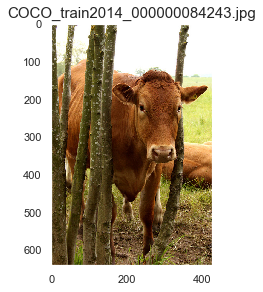

In [23]:
def search_captions(text, image_names, image_captions, reg, vectorizer, tree, img_folder="./data/test_A_images/"):
    # obtenemos el descrioptor
    descriptor = vectorizer.transform([text])
    # pred image vector
    pred_image_vec = reg.predict(descriptor)
    # find n best match
    dists, idxs = tree.query(pred_image_vec, k=5)
    
    # get image name of the best match
    name = image_names[idxs[0][0]]
    # get captions related to this image
    caps = []
    for img, cap in image_captions:
        if name == img:
            caps.append(cap)
    fig = plt.figure()
    img = mpimg.imread(img_folder + name)
    plt.imshow(img)
#     fig.set_xticklabels([])
#     fig.set_yticklabels([])
    plt.grid(b=None)
    plt.title(name, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    print("===> texto buscado: '{}'".format(text))
    print("===> mejor imagen relacionada al texto: '{}'".format(name))
    print("===> Captions relacionados a esta imagen:")
    for c in caps:
        print("    --> ", c)
search_captions("una vaca comiendo pasto", image_names, image_captions, search_reg, search_vectorizer, tree)

## Conclusiones finales

De lo estudiado en esta tarea se obtiene una gran variedad de resultados, algunos buenos, otro malos y otros difíciles de analizar.

Primero, sobre los descriptores de texto, se observa que todos logran describir a su modo los textos entregados, presentando el funcionamiento esperado pero no asi los resultados esperados. En particular, no existió diferencia notable en los resultados finales de las busquedas al cambiar el metodo para obtener los descriptores. Era esperable obtener resultados notoriamente mejores para TF-IDF. Una explicacion que puede ser plausible es el hecho de que la red regresional es pequeña y fue entrenada de tal forma que cambiar el vector de entrada afecta muy levemente a la regresión final, obteniendo siempre resultados muy similares.

Luego, retomando el punto del regressor. Se realizaron iteraciones no registradas con la cual se obtuvo como resultado que el tamaño escogido para nuestro regressor era aproximadamente el que mejor resultados entregaba. Se intento entrenar un regresor mas grande, pero dado que los datos son pocos se sobre ajustaba rápidamente obteniendo resultados mucho peores que con menos capas y/o neuronas. Es posible que utilizar PCA permita mejorar los resultados de estos regresores pero fue algo no explorado en esta tarea. Sobre la validación del regresor, se implementaron numerosas métricas de distancias que son usuales en médotos regresionales (MSE, MAE, RMSE y R2), obteniendo para todas el comportamiento óptimo, es decir, que el set de entrenamiento y el set de validación mantengan estas metricas en valores similares. Gracias a esto, podemos estar seguros que nuestro regresor no sobreajusta.

Luego obtuvimos los indicadores  para cada experimento realizado. Sobre estos resultados es dificil concluir objetivamente, dado que en todos los experimentos se obtuvieron valores muy similares. Se observa que TF-IDF es levemente mejor en algunos aspectos como promedio y MRR pero no es una diferencia concluyente, a priori ambos métodos son equivalentes para este experimento, pero se necesitan más datos objetivos. Sobre los resultados generales, se obtiene un promedio bastante alto (sobre los 100) para todos los experimentos, lo que significa que las búsquedas encuentran en promedio 100 imágenes diferentes a una distancia mejor que la imagen real. Por otro lado los recall indican que entre los mejores 1, 5 y 10 resultados, muy pocas veces se encuentra la imagen real. Todos estos datos nos sugieren que es necesario utilizar más datos, entrenar un mejor regresor y aplicar un mejor descriptor de texto para mejorar los resultados, pero aun asi, sabemos que estamos en el camino correcto dado que se observa una tendencia y estructura en las busquedas.


### Bibliografia
Se adjuntan links a todas las fuentes utilizadas durante este trabajo:
* http://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples
* https://medium.com/datadriveninvestor/building-neural-network-using-keras-for-regression-ceee5a9eadff
* https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
* https://datascienceplus.com/keras-regression-based-neural-networks/
* https://machinelearningmastery.com/save-load-keras-deep-learning-models/
* https://keras.io/callbacks/ 
* https://keras.io/models/sequential/ 
* https://keras.rstudio.com/articles/tutorial_overfit_underfit.html 
* https://pypi.org/project/stop-words/
* https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
* https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
* https://github.com/keras-team/keras/issues/3911
* https://github.com/keras-team/keras/issues/7947